In [1]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-05-24T20:00:37.367318Z","iopub.execute_input":"2025-05-24T20:00:37.367526Z","iopub.status.idle":"2025-05-24T20:01:58.285420Z","shell.execute_reply.started":"2025-05-24T20:00:37.367508Z","shell.execute_reply":"2025-05-24T20:01:58.284791Z"}}
# 🐝 YOLOv8 Bee Detection and StrongSORT Tracking Pipeline
# ==============================================
# Fine-tuned version to include tracking, classification (pollen/no pollen), and metrics as discussed in the IEEE paper.

# 📦 Install necessary packages
!pip install ultralytics deep_sort_realtime opencv-python-headless

import os
import shutil
import random
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import Video, Image

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-05-24T20:02:10.682548Z","iopub.execute_input":"2025-05-24T20:02:10.683244Z","iopub.status.idle":"2025-05-24T20:02:13.558484Z","shell.execute_reply.started":"2025-05-24T20:02:10.683217Z","shell.execute_reply":"2025-05-24T20:02:13.557703Z"}}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing install

In [2]:
# 🔄 Set random seed
random.seed(42)

# ==============================
# 📁 DATASET PREPARATION
# ==============================
dataset_path = '/kaggle/input/bee-identification/train'
output_path = '/kaggle/working/dataset'
os.makedirs(output_path, exist_ok=True)

for split in ['train', 'val', 'test']:
    os.makedirs(f'{output_path}/{split}/images', exist_ok=True)
    os.makedirs(f'{output_path}/{split}/labels', exist_ok=True)

# Filter valid image-label pairs
all_images = [os.path.splitext(f)[0] for f in os.listdir(f'{dataset_path}/images') if f.endswith(('jpg', 'png', 'jpeg'))]
valid_images = [img for img in all_images if os.path.exists(f'{dataset_path}/labels/{img}.txt') and os.path.getsize(f'{dataset_path}/labels/{img}.txt') > 0]

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-05-24T20:05:41.610821Z","iopub.execute_input":"2025-05-24T20:05:41.611550Z","iopub.status.idle":"2025-05-24T20:05:51.239667Z","shell.execute_reply.started":"2025-05-24T20:05:41.611524Z","shell.execute_reply":"2025-05-24T20:05:51.239093Z"}}

In [3]:
# Train/Val/Test Split
train_val, test = train_test_split(valid_images, test_size=0.05, random_state=42)
train, val = train_test_split(train_val, test_size=0.157, random_state=42)

def copy_files(basenames, img_src, lbl_src, img_dst, lbl_dst):
    for base in basenames:
        for ext in ['.jpg', '.jpeg', '.png']:
            if os.path.exists(f'{img_src}/{base}{ext}'):
                shutil.copy(f'{img_src}/{base}{ext}', f'{img_dst}/{base}{ext}')
                break
        shutil.copy(f'{lbl_src}/{base}.txt', f'{lbl_dst}/{base}.txt')

copy_files(train, f'{dataset_path}/images', f'{dataset_path}/labels', f'{output_path}/train/images', f'{output_path}/train/labels')
copy_files(val, f'{dataset_path}/images', f'{dataset_path}/labels', f'{output_path}/val/images', f'{output_path}/val/labels')
copy_files(test, f'{dataset_path}/images', f'{dataset_path}/labels', f'{output_path}/test/images', f'{output_path}/test/labels')

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-05-24T20:05:56.609654Z","iopub.execute_input":"2025-05-24T20:05:56.609919Z","iopub.status.idle":"2025-05-24T20:05:56.743533Z","shell.execute_reply.started":"2025-05-24T20:05:56.609899Z","shell.execute_reply":"2025-05-24T20:05:56.742866Z"}}

In [4]:
# ==============================
# 📝 DATA.YAML CONFIG
# ==============================
yaml_path = f'{output_path}/data.yaml'
with open(yaml_path, 'w') as f:
    f.write(f"""path: {output_path}
train: train/images
val: val/images
test: test/images
nc: 2
names: ['bee', 'bee_pollen']
""")

!cat {yaml_path}

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-05-24T20:06:02.839374Z","iopub.execute_input":"2025-05-24T20:06:02.840161Z","iopub.status.idle":"2025-05-24T20:41:48.837648Z","shell.execute_reply.started":"2025-05-24T20:06:02.840132Z","shell.execute_reply":"2025-05-24T20:41:48.836839Z"}}

path: /kaggle/working/dataset
train: train/images
val: val/images
test: test/images
nc: 2
names: ['bee', 'bee_pollen']


In [5]:
# ==============================
# 🎯 MODEL TRAINING
# ==============================
model = YOLO('yolov8m.pt')
results = model.train(
    data=yaml_path,
    epochs=150,
    batch=16,
    imgsz=640,
    device=0,
    pretrained=True,
    project='bee_detection',
    name='yolov8s_bee_pollen',
    exist_ok=True
)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2025-05-24T20:44:45.287336Z","iopub.execute_input":"2025-05-24T20:44:45.287636Z","iopub.status.idle":"2025-05-24T20:44:55.731873Z","shell.execute_reply.started":"2025-05-24T20:44:45.287615Z","shell.execute_reply":"2025-05-24T20:44:55.730671Z"}}

100%|██████████| 49.7M/49.7M [00:00<00:00, 248MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_bee_pollen, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 626.6±228.5 MB/s, size: 19.9 KB)


train: Scanning /kaggle/working/dataset/train/labels... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<00:00, 1448.27it/s]

train: New cache created: /kaggle/working/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 433.5±189.9 MB/s, size: 22.9 KB)


val: Scanning /kaggle/working/dataset/val/labels... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 906.77it/s]

val: New cache created: /kaggle/working/dataset/val/labels.cache


Plotting labels to bee_detection/yolov8s_bee_pollen/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to bee_detection/yolov8s_bee_pollen
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      6.11G      2.466      3.112      1.855         25        640: 100%|██████████| 43/43 [00:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        128        340    0.00703      0.376      0.005    0.00173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      7.28G      2.364      1.974       1.84         41        640: 100%|██████████| 43/43 [00:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        128        340      0.379      0.476      0.343      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      7.28G      2.334      1.882      1.827         21        640: 100%|██████████| 43/43 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        128        340      0.266      0.141     0.0855      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      7.28G      2.377      1.851      1.841         29        640: 100%|██████████| 43/43 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340   0.000214     0.0235   0.000109   4.34e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      7.28G      2.356      1.773      1.821         20        640: 100%|██████████| 43/43 [00:24<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        128        340      0.386      0.321      0.322      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      7.28G       2.32      1.744      1.822         48        640: 100%|██████████| 43/43 [00:24<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        128        340      0.276      0.185      0.133     0.0402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      7.28G      2.259      1.667      1.776         48        640: 100%|██████████| 43/43 [00:24<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        128        340      0.493      0.415      0.421       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      7.28G      2.261      1.736      1.759         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        128        340      0.536      0.547       0.54      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      7.28G      2.251       1.65      1.759         22        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.572      0.436      0.479      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      7.28G      2.202      1.632      1.759         36        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        128        340      0.391      0.285      0.283     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      7.28G      2.245       1.58      1.747         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.457      0.497      0.445      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      7.28G      2.188      1.604      1.742         33        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.449      0.315      0.338      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      7.28G      2.238      1.569      1.747         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340       0.44      0.409      0.387      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      7.28G      2.192      1.516      1.726         26        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.547      0.512      0.549      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      7.28G       2.16       1.53      1.703         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.545      0.521      0.533      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      7.28G      2.098      1.459      1.687         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.578      0.541      0.514      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      7.28G      2.157      1.523      1.695         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.455      0.106     0.0875     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      7.28G      2.111      1.465      1.684         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.611      0.532      0.567      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      7.28G      2.114      1.408      1.668         47        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.628      0.524      0.566      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      7.28G      2.092      1.388      1.681         47        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.603      0.488      0.536      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      7.28G      2.097      1.437      1.653         39        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        128        340      0.646      0.482      0.556      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      7.28G      2.105      1.378      1.685         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.619      0.579      0.615       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      7.28G      2.092      1.397       1.68         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.398      0.303      0.286     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      7.28G      2.048      1.362      1.645         41        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340       0.64      0.547      0.597      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      7.28G      2.043      1.367      1.631         56        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340       0.56      0.547      0.551      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      7.28G      2.051      1.321      1.636         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.615      0.518      0.548      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      7.28G      2.025      1.362      1.621         43        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.593      0.576      0.566      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      7.28G      2.043      1.336      1.643         45        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.587      0.571      0.606       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      7.28G      1.987      1.304      1.603         38        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.633      0.615      0.644      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      7.28G      1.991      1.267      1.609         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.625      0.559      0.612      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      7.28G      1.989       1.25      1.619         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.638      0.562        0.6      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      7.28G      1.973      1.265      1.604         28        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.635      0.618      0.628      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      7.28G       1.97      1.234      1.566         26        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.662      0.503      0.535      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      7.28G      2.001      1.275      1.547         43        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        128        340      0.615      0.559      0.603      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      7.28G      1.949      1.244      1.583         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.596      0.539      0.569      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      7.28G      1.932      1.194      1.567         26        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.653      0.614      0.654      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      7.28G       1.88      1.208       1.56         42        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.667      0.556      0.617       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      7.28G      1.888      1.173      1.533         44        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.702      0.624      0.684      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      7.28G      1.908      1.166      1.528         25        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.697      0.616      0.679      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      7.28G       1.86      1.119      1.531         39        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.629      0.535      0.581      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      7.28G      1.912       1.19      1.545         24        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.607      0.559      0.583      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      7.28G       1.87      1.144      1.559         23        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.657      0.585      0.616      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      7.28G       1.84      1.114       1.49         28        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.612      0.576      0.608      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      7.28G      1.825      1.081       1.52         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340       0.68      0.579      0.644      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      7.28G      1.844        1.1      1.534         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.688      0.562      0.646      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      7.28G      1.834      1.092      1.502         41        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.715      0.532       0.63      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      7.28G      1.835      1.091      1.515         31        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.656      0.604       0.64      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      7.28G      1.774      1.049      1.477         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.745      0.591      0.673      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      7.28G      1.759      1.029      1.482         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340       0.67      0.638      0.675      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      7.28G       1.77      1.023      1.464         38        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.701      0.648      0.684      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      7.28G      1.793      1.002      1.494         25        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.677       0.64      0.659      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      7.28G      1.775      1.013      1.498         28        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.628      0.556      0.625      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      7.28G      1.776      1.005      1.471         18        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.643      0.615      0.652      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      7.28G      1.755     0.9996      1.467         35        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.691      0.618      0.671      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      7.28G      1.692     0.9532      1.417         57        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        128        340       0.68      0.618       0.62      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      7.28G      1.674     0.9666      1.407         27        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.642      0.562      0.588      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      7.28G      1.718     0.9645      1.433         18        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.739      0.621      0.681      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      7.28G      1.654     0.9157      1.407         40        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.615      0.658      0.659      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      7.28G      1.707     0.9757      1.436         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.567      0.512      0.514      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      7.28G      1.699     0.9513      1.432         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.692      0.585      0.656      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      7.28G      1.659     0.9079       1.41         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.633      0.603      0.642      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      7.28G      1.604     0.8811      1.386         16        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.717      0.562      0.647      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      7.28G      1.642     0.8896      1.371         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.583      0.613      0.615      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      7.28G      1.605     0.8813      1.394         70        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340       0.71      0.519      0.611      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      7.28G      1.579      0.873       1.38         43        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.686      0.621      0.644      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      7.28G      1.591     0.8878      1.386         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.682      0.562      0.642      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      7.28G      1.529     0.8502      1.337         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.676      0.588      0.624      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      7.28G      1.562     0.8508      1.353         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.702      0.615      0.636      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      7.28G      1.584     0.8698      1.368         27        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340        0.7      0.565      0.628      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      7.28G      1.517     0.8289       1.33         50        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.664      0.626      0.653      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      7.28G      1.503     0.8185      1.311         56        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.665      0.647      0.662      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      7.28G      1.488     0.7944      1.326         41        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.706       0.62      0.665      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      7.28G      1.501      0.795      1.323         49        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.706      0.644      0.661      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      7.28G      1.485     0.7872      1.306         56        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.725      0.559      0.649      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      7.28G      1.507     0.7988      1.326         51        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.682        0.6      0.611      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      7.28G      1.472     0.7834      1.285         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.653      0.591        0.6      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      7.28G      1.469     0.7956      1.331         44        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.711      0.662      0.671      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      7.28G      1.414     0.7671      1.309         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.689      0.612      0.656      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      7.28G      1.432     0.7552      1.276         28        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.691      0.576      0.632      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      7.28G      1.428     0.7597      1.302         40        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        128        340      0.681      0.665      0.667      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      7.28G      1.396     0.7331      1.273         22        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.688      0.638      0.661      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      7.28G      1.401     0.7468      1.275         40        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.663      0.647      0.655      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      7.28G      1.395     0.7401      1.252         29        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340       0.66      0.632       0.64      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      7.28G      1.351     0.7267      1.241         26        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.696      0.615      0.653      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      7.28G       1.35     0.7169      1.244         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.693      0.611      0.639      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      7.28G      1.328     0.7024      1.216         36        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.685      0.619      0.656      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      7.28G      1.307     0.6768      1.227         35        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.619      0.641       0.64      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      7.28G      1.335     0.7023      1.217         36        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.664      0.635      0.645      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      7.28G      1.307     0.6774      1.221         22        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.707      0.585      0.622       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      7.28G      1.303      0.682      1.216         27        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.637      0.612      0.615      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      7.28G      1.313     0.6831      1.218         59        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.669      0.615      0.637      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      7.28G      1.262     0.6584      1.193         33        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.675      0.615      0.651      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      7.28G      1.241     0.6416      1.183         48        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.689      0.621      0.635      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      7.28G      1.265     0.6476      1.205         38        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.674      0.624      0.629      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      7.28G      1.238     0.6408      1.187         40        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.675      0.635      0.631      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      7.28G      1.235     0.6482      1.189          9        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340       0.72      0.594      0.662      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      7.28G      1.226     0.6405      1.188         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.678      0.618      0.639      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      7.28G      1.207     0.6308       1.16         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.689      0.612      0.639      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      7.28G      1.222      0.635       1.19         26        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.741      0.556      0.632      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      7.28G      1.204     0.6286      1.172         28        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.673      0.638      0.663      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      7.28G      1.169     0.6102       1.14         21        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340       0.68      0.629      0.655      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      7.28G      1.146      0.586       1.14         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340       0.71      0.585      0.635      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      7.28G      1.176     0.6003       1.16         34        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.686      0.588      0.626      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      7.28G      1.133     0.6011      1.143         46        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.691      0.662      0.679      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      7.28G      1.167     0.5947      1.137         36        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.721      0.639      0.649      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      7.28G      1.158     0.5858      1.136         41        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.719      0.588       0.64      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      7.28G      1.131     0.5892      1.134         41        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.668      0.585      0.633      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      7.28G      1.134      0.581      1.117         25        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.747      0.582      0.658      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      7.28G      1.113     0.5725      1.104         36        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.675      0.643      0.636      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      7.28G      1.126     0.5789      1.119         22        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        128        340      0.672      0.639      0.639       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      7.28G      1.099     0.5607      1.104         35        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.732      0.579      0.655      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      7.28G      1.104     0.5751      1.118         33        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.679      0.641      0.646       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      7.28G      1.115     0.5846      1.115         15        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340      0.668      0.639      0.636      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      7.28G      1.088     0.5597      1.106         31        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340       0.71      0.621      0.636      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      7.28G      1.056     0.5502      1.093         39        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.672      0.668      0.659      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      7.28G      1.051     0.5569       1.09         42        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.716      0.591      0.658      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      7.28G      1.048     0.5478      1.091         22        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        128        340       0.73      0.624       0.66      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      7.28G      1.058     0.5603      1.116         20        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.687      0.588      0.625      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      7.28G      1.032     0.5389      1.081         33        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.701      0.614      0.655      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      7.28G      1.015     0.5323      1.077         38        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.658      0.618       0.64       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      7.28G      1.022     0.5285      1.068         24        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.711      0.622      0.668      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      7.28G      1.037     0.5241       1.09         37        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.761      0.597      0.664      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      7.28G      1.012     0.5286       1.09         22        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.701      0.628      0.651      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      7.28G     0.9735     0.5006      1.059         28        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.707      0.626      0.647      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      7.28G      1.007     0.5287      1.079         38        640: 100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.686      0.609      0.654       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      7.28G     0.9811     0.5114       1.06         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.722      0.626      0.676      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      7.28G     0.9522     0.4986      1.022         31        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.733      0.615      0.674       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      7.28G     0.9786     0.5076      1.061         27        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.686      0.579       0.63      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      7.28G     0.9647     0.4947      1.061         46        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        128        340      0.672      0.621      0.643      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      7.28G          1     0.5271      1.068         15        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.703      0.667      0.671      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      7.28G     0.9767     0.5091       1.04         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.747      0.612      0.687      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      7.28G     0.9519     0.4949      1.049         33        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.727      0.629       0.68      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      7.28G     0.9231      0.489      1.043         35        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340       0.69      0.667      0.671      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      7.28G     0.9316     0.5041      1.042         21        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340       0.74      0.606      0.656      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      7.28G     0.9397     0.4923      1.046         30        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.728      0.621      0.662      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      7.28G     0.9189     0.4899       1.03         54        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.738      0.609      0.655      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      7.28G     0.9018      0.485       1.03         15        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.718      0.636      0.656      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      7.28G     0.9106      0.486      1.018         19        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.698      0.647      0.659      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      7.28G     0.8793      0.474      1.017         32        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.707      0.653      0.671      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      7.28G     0.8852     0.4684       1.01         49        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.687      0.626      0.651      0.241


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      7.28G     0.8828     0.4446      1.052         24        640: 100%|██████████| 43/43 [00:25<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        128        340      0.691        0.6      0.644      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      7.28G     0.8565     0.4389      1.033         25        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.699      0.574      0.621      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      7.28G     0.8179     0.4258      1.031         18        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.703      0.606      0.648       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      7.28G     0.8232      0.442      1.044         16        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.691      0.615      0.645      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      7.28G     0.8118     0.4206      1.028         18        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.699      0.616      0.655      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      7.28G     0.7871     0.4078      1.018         26        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        128        340      0.698      0.606      0.652      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      7.28G     0.7719     0.3984      0.995         23        640: 100%|██████████| 43/43 [00:24<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        128        340      0.707       0.61       0.64      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      7.28G     0.7747     0.4016      1.015         20        640: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.697      0.618      0.649       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      7.28G      0.779     0.4024      1.014         21        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.719      0.603      0.655      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      7.28G     0.7723     0.4008      1.009         19        640: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        128        340      0.684      0.612      0.647      0.236



150 epochs completed in 1.134 hours.
Optimizer stripped from bee_detection/yolov8s_bee_pollen/weights/last.pt, 52.0MB
Optimizer stripped from bee_detection/yolov8s_bee_pollen/weights/best.pt, 52.0MB

Validating bee_detection/yolov8s_bee_pollen/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        128        340      0.744      0.612      0.687      0.258
                   bee        128        340      0.744      0.612      0.687      0.258
Speed: 0.2ms preprocess, 11.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to bee_detection/yolov8s_bee_pollen


In [6]:
# ==============================
# 🎯 FULL VIDEO TRACKING SCRIPT
# ==============================

import cv2
import os
import shutil
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import Video

# Load YOLOv8 trained model
model = YOLO('/kaggle/working/bee_detection/yolov8s_bee_pollen/weights/best.pt')

# Initialize DeepSORT
deep_sort = DeepSort(max_age=30, n_init=3)

# Tracking function
def track_bees(video_path, save_path, conf_thresh=0.4):
    cap = cv2.VideoCapture(video_path)
    fps, width, height = int(cap.get(5)), int(cap.get(3)), int(cap.get(4))
    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Finished processing.")
            break

        results = model.predict(frame, conf=conf_thresh, imgsz=640)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()
        clss = results.boxes.cls.cpu().numpy()

        detections = [(box, conf, int(cls_)) for box, conf, cls_ in zip(boxes, confs, clss)]
        tracks = deep_sort.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue
            x1, y1, x2, y2 = track.to_ltrb()
            track_id = track.track_id
            cls = track.det_class
            label = f"{['Bee', 'Bee Pollen'][cls]} #{track_id}"
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
            cv2.putText(frame, label, (int(x1), int(y1)-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        out.write(frame)

    cap.release()
    out.release()

# === Run tracking on your video
input_video = '/kaggle/input/pest-and-bee/1_2024-09-09_180010.mp4'
output_video = '/kaggle/working/bee_tracking_output.mp4'
track_bees(input_video, output_video)

# === Optional: View video inside notebook
Video(output_video, embed=True)

# === Prepare for download
# download_path = "kaggle/data/bee_tracking_output.mp4"
# if os.path.exists(output_video):
#     shutil.copy(output_video, download_path)
#     print(f"✅ Download ready at: {download_path}")
# else:
#     print("❌ Output video not found.")



0: 384x640 (no detections), 41.3ms
Speed: 1.7ms preprocess, 41.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bee, 25.1ms
Speed: 1.8ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 21.3ms
Speed: 1.7ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 21.4ms
Speed: 1.8ms preprocess, 21.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 bees, 21.4ms
Speed: 1.7ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 bees, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 1.5ms postprocess 

Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/bee_detection/yolov8s_bee_pollen/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (49.6 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...


Using Python 3.11.11 environment at: /usr
Resolved 22 packages in 313ms
 Downloaded onnxruntime-gpu
Prepared 4 packages in 3.14s
Installed 4 packages in 23ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.22.0
 + onnxslim==0.1.57



requirements: AutoUpdate success ✅ 4.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 8.2s, saved as '/kaggle/working/bee_detection/yolov8s_bee_pollen/weights/best.onnx' (98.8 MB)

Export complete (9.6s)
Results saved to /kaggle/working/bee_detection/yolov8s_bee_pollen/weights
Predict:         yolo predict task=detect model=/kaggle/working/bee_detection/yolov8s_bee_pollen/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/bee_detection/yolov8s_bee_pollen/weights/best.onnx imgsz=640 data=/kaggle/working/dataset/data.yaml  
Visualize:       https://netron.app

image 1/1 /kaggle/working/dataset/test/images/1_2025-01-07_120006_frame90_jpg.rf.bb15e6952a539b28e798e7026d4d7602.jpg: 640x640 (no detections), 37.9ms
Speed: 1.7ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640

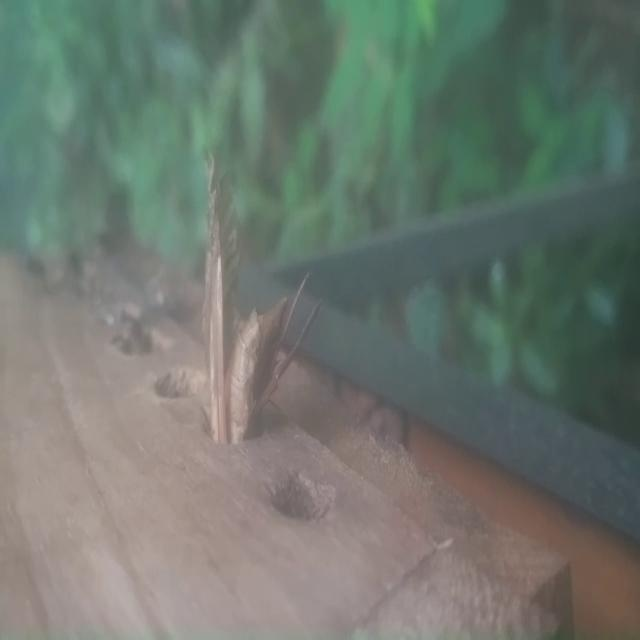

In [7]:
# ==============================
# 📊 METRICS EXPORT (OPTIONAL)
# ==============================
# Save model weights
!cp /kaggle/working/bee_detection/yolov8s_bee_pollen/weights/best.pt /kaggle/working/bee_detector.pt

# Export ONNX
model.export(format='onnx')

# Preview on test image
sample_image = f'{output_path}/test/images/{os.listdir(f"{output_path}/test/images")[0]}'
results = model.predict(sample_image, conf=0.25, iou=0.45, save=True)
Image(filename=results[0].save_dir + '/' + os.path.basename(sample_image))

# %% [code]